# Regression Model for Kaggle Tabular Playground Series January 2021 Using TensorFlow Decision Forests
### David Lowe
### November 22, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series January 2021 dataset is a regression situation where we are trying to predict the value of a continuous variable.

Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have been hosting playground-style competitions on Kaggle with fun but less complex, tabular datasets. These competitions will be great for people looking for something between the Titanic Getting Started competition and a Featured competition.

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved an RMSE benchmark of 0.7013 on the validation dataset. The final model processed the validation dataset with a final RMSE score of 0.7006. When we applied the finalized model to Kaggle's test dataset, the model achieved an RMSE score of 0.7031.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series January 2021 Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-jan-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-jan-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL
!pip install tensorflow_decision_forests

     |████████████████████████████████| 17.1 MB 129 kB/s 


In [2]:
!pip install wurlitzer

In [3]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [4]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [5]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

In [8]:
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [9]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
MAX_EPOCHS = 10
BATCH_SIZE = 32

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# # Print out the TensorFlow version for confirmation
# print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.2.1


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id     cont1     cont2     cont3  ...    cont12    cont13    cont14    target
0   1  0.670390  0.811300  0.643968  ...  0.866772  0.878733  0.305411  7.243043
1   3  0.388053  0.621104  0.686102  ...  0.434971  0.369957  0.369484  8.203331
2   4  0.834950  0.227436  0.301584  ...  0.677708  0.882938  0.303047  7.776091
3   5  0.820708  0.160155  0.546887  ...  0.818143  0.914281  0.279528  6.957716
4   8  0.935278  0.421235  0.303801  ...  0.900464  0.935918  0.435772  7.951046

[5 rows x 16 columns]


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [15]:
print(df_dataset_import.describe())

                  id          cont1  ...         cont14         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean   249825.145857       0.506873  ...       0.503713       7.905661
std    144476.732562       0.203976  ...       0.208238       0.733071
min         1.000000      -0.082263  ...       0.166367       0.000000
25%    124656.500000       0.343078  ...       0.308673       7.329367
50%    249738.500000       0.484005  ...       0.431845       7.940571
75%    374836.250000       0.643789  ...       0.712653       8.470084
max    499999.000000       1.016227  ...       0.868506      10.267569

[8 rows x 16 columns]


In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [17]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

      cont1     cont2     cont3  ...    cont13    cont14    target
0  0.670390  0.811300  0.643968  ...  0.878733  0.305411  7.243043
1  0.388053  0.621104  0.686102  ...  0.369957  0.369484  8.203331
2  0.834950  0.227436  0.301584  ...  0.882938  0.303047  7.776091
3  0.820708  0.160155  0.546887  ...  0.914281  0.279528  6.957716
4  0.935278  0.421235  0.303801  ...  0.935918  0.435772  7.951046

[5 rows x 15 columns]


In [18]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont1   300000 non-null  float64
 1   cont2   300000 non-null  float64
 2   cont3   300000 non-null  float64
 3   cont4   300000 non-null  float64
 4   cont5   300000 non-null  float64
 5   cont6   300000 non-null  float64
 6   cont7   300000 non-null  float64
 7   cont8   300000 non-null  float64
 8   cont9   300000 non-null  float64
 9   cont10  300000 non-null  float64
 10  cont11  300000 non-null  float64
 11  cont12  300000 non-null  float64
 12  cont13  300000 non-null  float64
 13  cont14  300000 non-null  float64
 14  target  300000 non-null  float64
dtypes: float64(15)
memory usage: 34.3 MB


In [19]:
print(df_dataset_import.describe())

               cont1          cont2  ...         cont14         target
count  300000.000000  300000.000000  ...  300000.000000  300000.000000
mean        0.506873       0.497898  ...       0.503713       7.905661
std         0.203976       0.228159  ...       0.208238       0.733071
min        -0.082263      -0.031397  ...       0.166367       0.000000
25%         0.343078       0.319170  ...       0.308673       7.329367
50%         0.484005       0.553209  ...       0.431845       7.940571
75%         0.643789       0.731263  ...       0.712653       8.470084
max         1.016227       0.859697  ...       0.868506      10.267569

[8 rows x 15 columns]


In [20]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [21]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 15) df_features_train.shape: (300000, 14) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

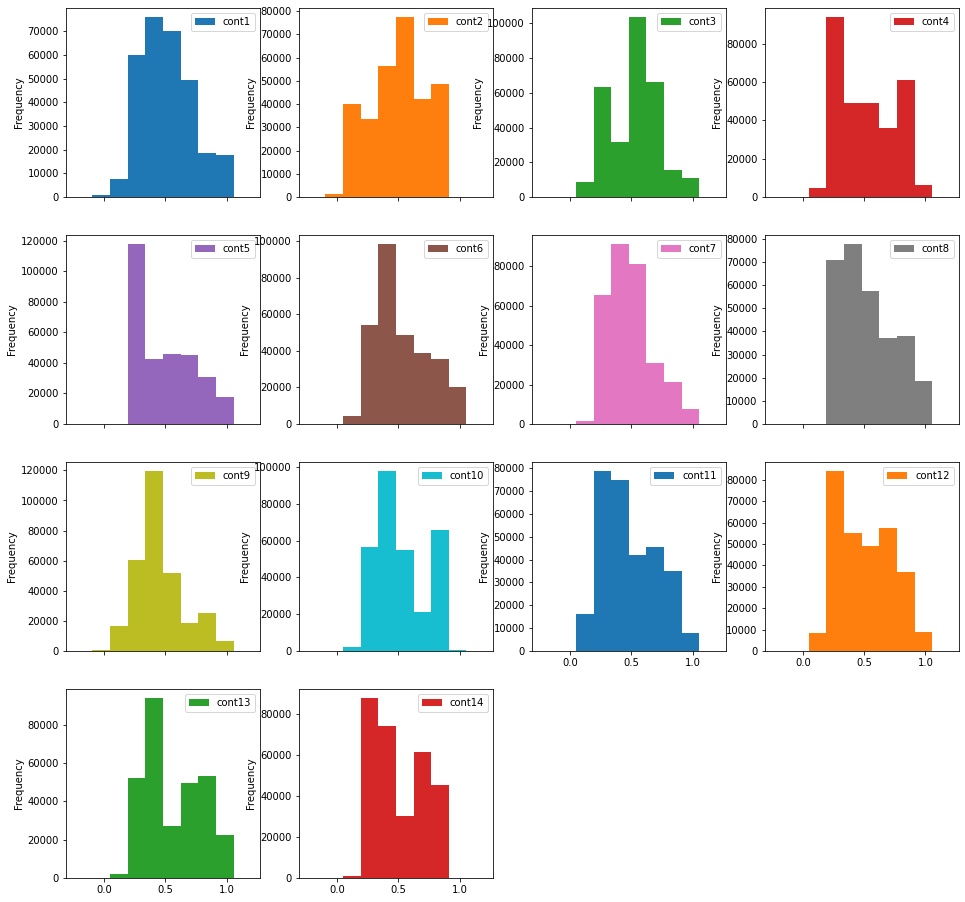

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

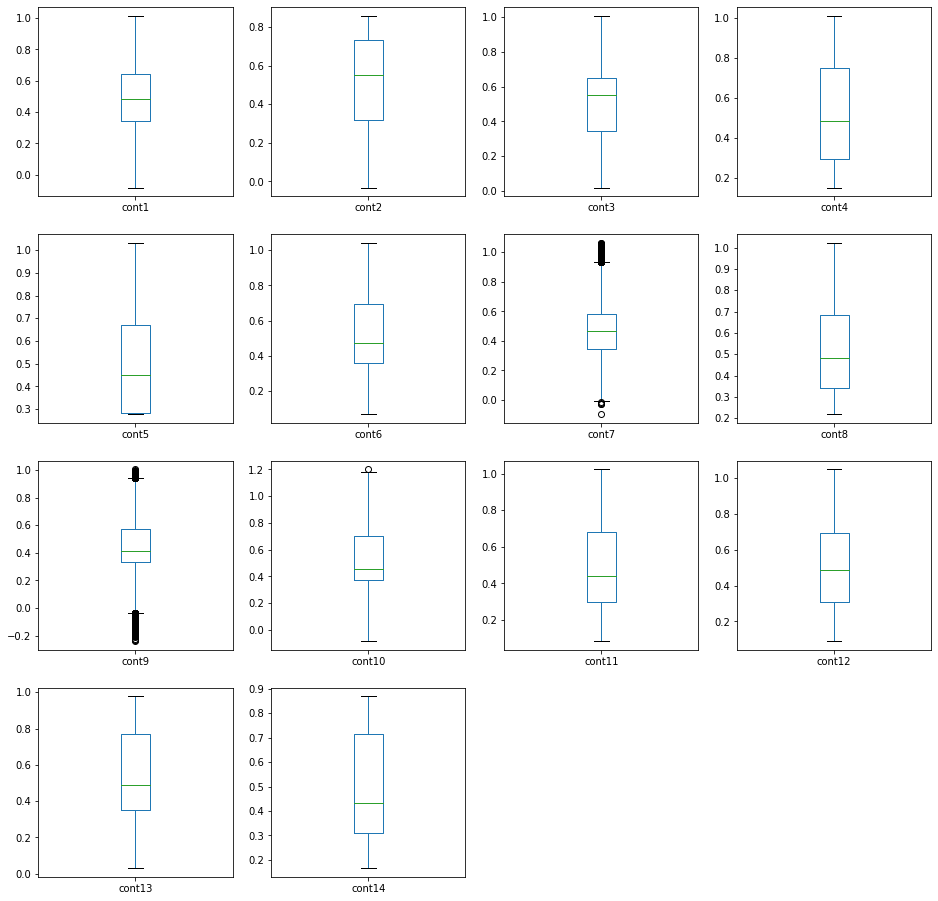

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

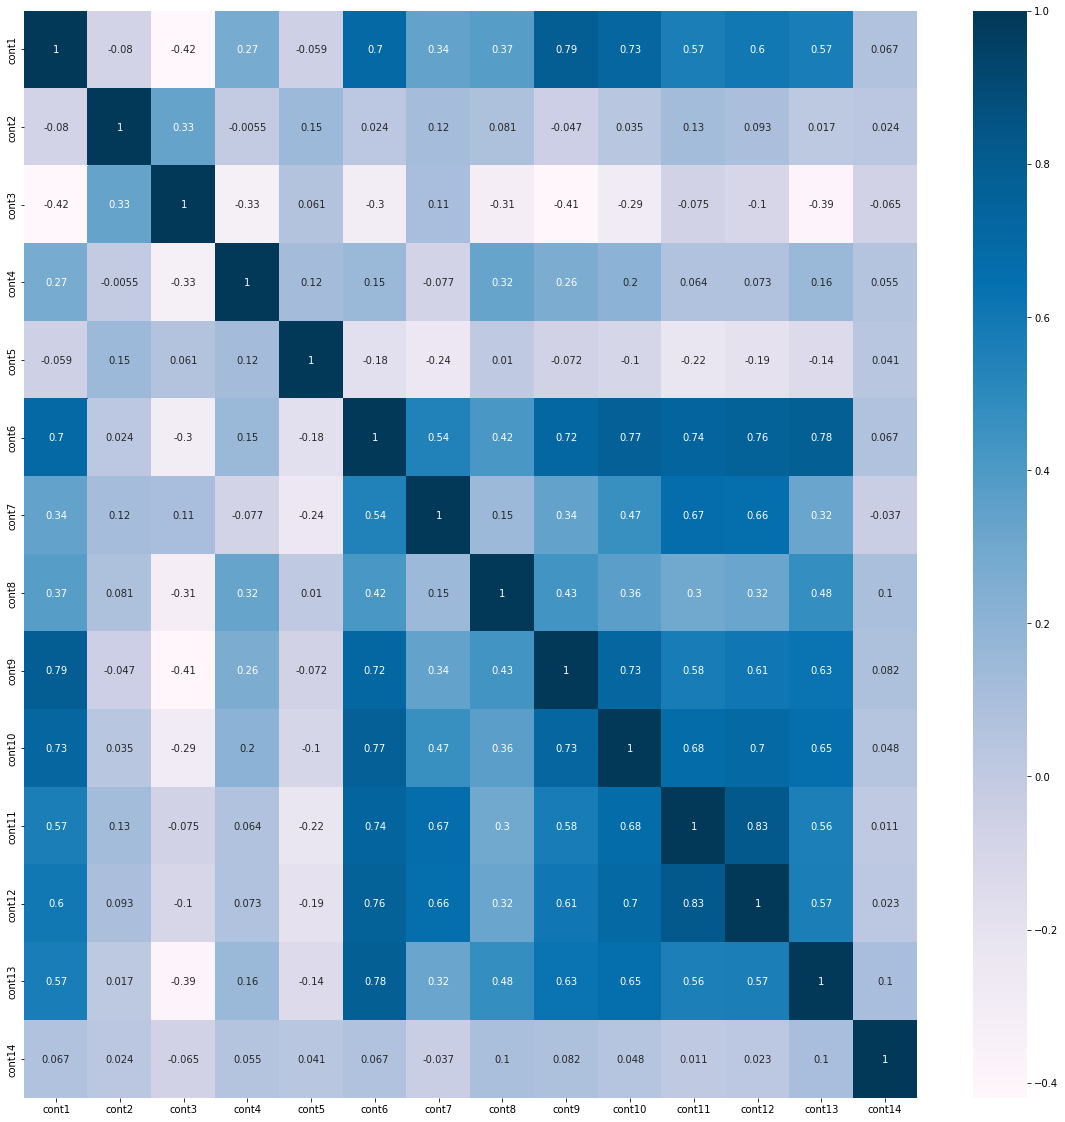

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [30]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (240000, 15) df_dataset_valid.shape: (60000, 15)


In [31]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.REGRESSION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task = tfdf.keras.Task.REGRESSION)

### 3.b) Train and Evaluate the Random Forest Model

In [32]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
RF_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3731/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 425s 112ms/step
Model training time: 0:07:29.683693 



In [33]:
RF_eval = RF_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 9s 9ms/step - loss: 0.0000e+00 - rmse: 0.7047

loss: 0.0000
rmse: 0.7047


In [34]:
tfdf.model_plotter.plot_model_in_colab(RF_model)

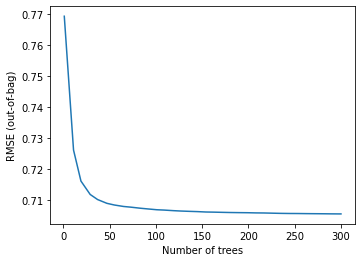

In [35]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")

plt.show()

### 3.c) Train and Evaluate the Decision Trees Model

In [36]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
CART_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3744/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 11s 3ms/step


[INFO kernel.cc:828] Export model in log directory: /tmp/tmpkdf88836
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[WARNING utils.cc:73] The model does not have any input features i.e. the model is constant and will always return the same prediction.
[INFO decision_forest.cc:590] Model loaded with 1 root(s), 1 node(s), and 0 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestOptPred" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:00:20.830486 



In [37]:
CART_eval = CART_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - rmse: 5.6343

loss: 0.0000
rmse: 5.6343


In [38]:
tfdf.model_plotter.plot_model_in_colab(CART_model)

### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [39]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
GBT_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3726/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 268s 71ms/step
Model training time: 0:04:27.770381 



In [61]:
GBT_eval = GBT_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - rmse: 0.7013

loss: 0.0000
rmse: 0.7013


In [41]:
tfdf.model_plotter.plot_model_in_colab(GBT_model)

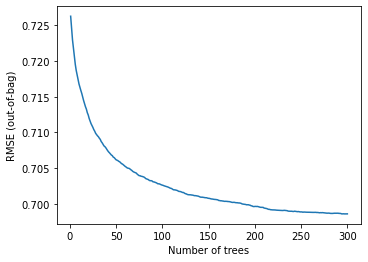

In [42]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")

plt.show()

In [43]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [44]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [62]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    reset_random()
    Tuning_model = tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, task = tfdf.keras.Task.REGRESSION)

    # Optionally, add evaluation metrics.
    Tuning_model.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    Tuning_model.fit(x=tfds_train, verbose=False)

    tuning_eval = Tuning_model.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in tuning_eval.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7013

loss: 0.0000
rmse: 0.7013
Model optimization time: 0:05:24.900416 

938/938 [==============================] - 2s 3ms/step - loss: 0.0000e+00 - rmse: 0.7011

loss: 0.0000
rmse: 0.7011
Model optimization time: 0:06:25.109755 

938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7010

loss: 0.0000
rmse: 0.7010
Model optimization time: 0:06:24.934956 

938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7009

loss: 0.0000
rmse: 0.7009
Model optimization time: 0:06:21.308488 



In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [48]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=1000, task = tfdf.keras.Task.REGRESSION)

# Optionally, add evaluation metrics.
Final_model.compile(
    metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3730/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 15

Number of columns by type:
	NUMERICAL: 15 (100%)

Columns:

NUMERICAL: 15 (100%)
	0: "cont1" NUMERICAL mean:0.506927 min:-0.0772377 max:1.01623 sd:0.204115
	1: "cont10" NUMERICAL mean:0.520411 min:-0.085046 max:1.19995 sd:0.201994
	2: "cont11" NUMERICAL mean:0.483942 min:0.0832767 max:1.02262 sd:0.22019
	3: "cont12" NUMERICAL mean:0.506728 min:0.091488 max:1.04903 sd:0.218957
	4: "cont13" NUMERICAL mean:0.55341 min:0.0353633 max:0.977845 sd:0.229728
	5: "cont14" NUMERICAL mean:0.503661 min:0.166367 max:0.868506 sd:0.208206
	6: "cont2" NUMERICAL mean:0.497598 min:-0.0313975 max:0.859697 sd:0.22809
	7: "cont3" NUMERICAL mean:0.521296 min:0.0209669 max:1.00695 sd:0.200616
	8: "cont4" NUMERICAL mean:0.515783 min:0.154548 ma

3750/3750 [==============================] - 382s 102ms/step
Model training time: 0:06:22.371746 



In [49]:
Final_model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (14):
	cont1
	cont10
	cont11
	cont12
	cont13
	cont14
	cont2
	cont3
	cont4
	cont5
	cont6
	cont7
	cont8
	cont9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  4.884836 ################
    2.   "cont1"  4.142121 ####
    3.   "cont8"  4.106256 ###
    4.   "cont7"  4.104021 ###
    5.  "cont11"  4.097224 ###
    6.   "cont2"  4.057401 ###
    7.   "cont9"  4.032707 ##
    8.   "cont5"  4.022533 ##
    9.  "cont14"  4.008258 ##
   10.  "cont13"  3.993547 ##
   11.  "cont12"  3.985177 ##
   12.   "cont6"  3.947373 #
   13.   "cont3"  3.943475 #
   14.  "cont10"  3.937312 #
   15.   "cont4"  3.85521

In [50]:
tfdf.model_plotter.plot_model_in_colab(Final_model)

In [63]:
Final_eval = Final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 3s 3ms/step - loss: 0.0000e+00 - rmse: 0.7006

loss: 0.0000
rmse: 0.7006


### 5.b) Load Test Dataset and Prepare the Submission File

In [52]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jan/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id     cont1     cont2     cont3  ...    cont11    cont12    cont13    cont14
0   0  0.353600  0.738780  0.600939  ...  0.550540  0.699134  0.286864  0.364515
1   2  0.907222  0.189756  0.215531  ...  0.446475  0.449037  0.916964  0.513002
2   6  0.179287  0.355353  0.623972  ...  0.211913  0.222651  0.327164  0.827941
3   7  0.359385  0.181049  0.551368  ...  0.445276  0.518485  0.299028  0.598166
4  10  0.335791  0.682607  0.676481  ...  0.817721  0.805895  0.790591  0.249275

[5 rows x 15 columns]


In [53]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   0
1   2
2   6
3   7
4  10


In [54]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

      cont1     cont2     cont3  ...    cont12    cont13    cont14
0  0.353600  0.738780  0.600939  ...  0.699134  0.286864  0.364515
1  0.907222  0.189756  0.215531  ...  0.449037  0.916964  0.513002
2  0.179287  0.355353  0.623972  ...  0.222651  0.327164  0.827941
3  0.359385  0.181049  0.551368  ...  0.518485  0.299028  0.598166
4  0.335791  0.682607  0.676481  ...  0.805895  0.790591  0.249275

[5 rows x 14 columns]


In [55]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test, task = tfdf.keras.Task.REGRESSION)

In [56]:
# Make batched predictions
test_predictions = Final_model.predict(tfds_test)
print(test_predictions)

[[7.9471517]
 [7.8515325]
 [7.91051  ]
 ...
 [7.9942436]
 [8.031649 ]
 [7.947554 ]]


In [57]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   0  7.947152
1   2  7.851532
2   6  7.910510
3   7  8.272182
4  10  8.282704


In [58]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20211122-0117.csv


In [59]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [60]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:43:56.769768
